# Generating Dataset for Time Alignment Study

by Jacob Stallings

In [ ]:
#hide
#all_slow

In [ ]:
import os
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import torch
import librosa
from fastai.data.all import *
from fastproaudio.core import *
from tqdm import trange

In [ ]:
path_audiomdpi = get_audio_data(URLs.MARCO)
horn = path_audiomdpi / "LeslieHorn"; horn.ls()
path_dry = horn /'dry'
audio_extensions = ['.m3u', '.ram', '.au', '.snd', '.mp3','.wav']
fnames_dry = get_files(path_dry, extensions=audio_extensions)
PATH = horn 

In [ ]:
# First, resample with librosa
y, sr = librosa.load(os.path.join(PATH, fnames_dry[0]), sr=44100)
y_16k = librosa.resample(y, sr, 16000)
y.shape, y_16k.shape


((110250,), (40000,))

In [ ]:
# waveform, sample_rate = torchaudio.load(os.path.join(PATH,fnames_dry[0]))
sample = y_16k

In [ ]:


sample_rate = 16000
track_length = sample_rate*4
grid_interval = sample_rate # 1 sec

n_intervals = track_length // grid_interval

target = np.zeros(track_length)
input = np.zeros(track_length)
click = np.zeros(track_length)



In [ ]:

for i in range(n_intervals):
    # sample = waveform.numpy() # just simplify array dimensions for this demo
    # sample = sample[int(0.6*sample_rate):]  # chop off the silence at the front for this demo
    fname = random.choice(fnames_dry)
    #fnames_dry.remove(fname)
    y, sr = librosa.load(os.path.join(PATH, fname), sr=44100)
    y_16k = librosa.resample(y, sr, 16000)
    sample = y_16k

    # Randomly flip the phase
    if np.random.rand() > 0.5: sample *= -1


    # Chop off silence
    # Get the first nonzero value
    onset = np.nonzero(sample)[0][0]
    sample = sample[onset:]

    # Detect the loudest part of the audio and split it there
    peak = np.argmax(sample)
    sample_pre = sample[peak-2000:peak]
    sample_post = sample[peak:]


    sample_len = sample.shape[-1]
    sample_len_post = sample_post.shape[-1]
    sample_len_pre = sample_pre.shape[-1]
    # target = np.zeros(track_length+sample_len_pre)
    # input = np.zeros(track_length+ sample_len_pre)
    # click = np.zeros(track_length)

    start = grid_interval*i + sample_len_pre
    click[start] = 1                          # click track
    end_post = min(start + sample_len_post, track_length)
    end = min(start+sample_len, track_length)
    target[start:end_post] = sample_post[0:end_post-start]  # paste the sample on the grid
    target[grid_interval*i:start] = sample_pre
    print('hi')
    # mess up the paste location
    rand_start = max(0, start-sample_len_pre + np.random.randint(-grid_interval//4,grid_interval//4))
    print(start-sample_len_pre, rand_start)
    rand_end = min( rand_start+sample_len, track_length )
    input[rand_start:rand_end] = sample[0:rand_end-rand_start]

hi
0 2556
hi
16000 19943
hi
32000 31663
hi
48000 51100


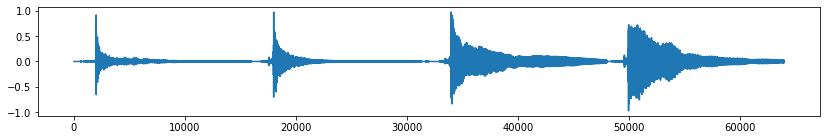

In [ ]:
fig = plt.figure(figsize=(14, 2))
plt.plot(target)

Regarding the above, we want to include the onset of the transient but not the silence in the beginning of the clips. We could do a linear search of the sample from the left to find the first nonzero value, then clip the sound from there and paste it so that the grid corresponds with the max

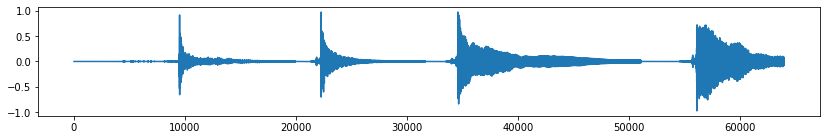

In [ ]:
fig = plt.figure(figsize=(14, 2))
plt.plot(input)

Note how the onset of the transients is preserved at the cost of chopping off some of the tails. This tradeoff happens in real single-track editing as well, but we could make the decision to prioritize keeping the tails of the previous hit and dropping the onset of the transient of the next hit.

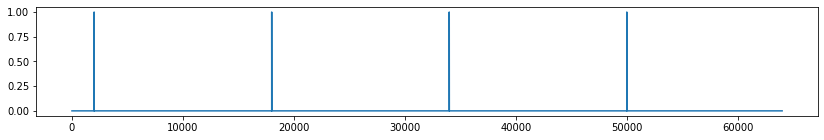

In [ ]:
fig = plt.figure(figsize=(14, 2))
plt.plot(click)

In [ ]:
def gen_pairs(fnamelist, sample_rate=16000, bpm=60, preserve_onset=True, num_hits=4):

    track_length = sample_rate*num_hits
    grid_interval = sample_rate
    n_intervals = track_length // grid_interval

    target = np.zeros(track_length)
    input = np.zeros(track_length)
    click = np.zeros(track_length)

    
    for i in range(n_intervals):
        # sample = waveform.numpy() # just simplify array dimensions for this demo
        # sample = sample[int(0.6*sample_rate):]  # chop off the silence at the front for this demo
        if len(fnamelist) <= 0: break
        fname = random.choice(fnamelist)
        #fnamelist.remove(fname)
        y, sr = librosa.load(os.path.join(PATH, fname), sr=44100)
        y_16k = librosa.resample(y, sr, 16000)
        sample = y_16k

        # Randomly flip the phase
        if np.random.rand() > 0.5: sample *= -1


        # Chop off silence
        # Get the first nonzero value
        onset = np.nonzero(sample)[0][0]
        sample = sample[onset:]

        # Detect the loudest part of the audio and split it there
        peak = np.argmax(sample)
        sample_pre = sample[peak-2000:peak]
        sample_post = sample[peak:]


        sample_len = sample.shape[-1]
        sample_len_post = sample_post.shape[-1]
        sample_len_pre = sample_pre.shape[-1]
        # target = np.zeros(track_length+sample_len_pre)
        # input = np.zeros(track_length+ sample_len_pre)
        # click = np.zeros(track_length)

        start = grid_interval*i + sample_len_pre
        click[start] = 1                          # click track
        end_post = min(start + sample_len_post, track_length)
        end = min(start+sample_len, track_length)
        target[start:end_post] = sample_post[0:end_post-start]  # paste the sample on the grid
        target[grid_interval*i:start] = sample_pre
        #print('hi')
        # mess up the paste location
        rand_start = max(0, start-sample_len_pre + np.random.randint(-grid_interval//4,grid_interval//4))
        #print(start-sample_len_pre, rand_start)
        rand_end = min( rand_start+sample_len, track_length )
        input[rand_start:rand_end] = sample[0:rand_end-rand_start]
    
    return input, target, click

Let's generate a trial dataset of let's say, 10 of these trios. (Eventually, we want to do the whole `LeslieHorn/dry` set).

In [ ]:
# basedir = './Data/time_align/data/'
foldername = 'timeAlignData_mono4'
if not os.path.isdir(foldername): os.mkdir(foldername)
bpm = 60

# Make all the dirs
for sub in ['Train', 'Test', 'Val']:
    if not os.path.isdir(os.path.join(foldername, sub)) : os.mkdir(os.path.join(foldername, sub))

train_split = 0.7

fnames_0 = fnames_dry[:len(fnames_dry)//2]
fnames_1 = fnames_dry[len(fnames_dry)//2:]


if len(fnames_0) < len(fnames_1) : size = len(fnames_0)
else: size = len(fnames_1)

size = size//2  # making it smaller at first!
print('size',size)
    
for idx in trange(size):
    if idx / size > 0.9: subset = 'Test'
    elif idx / size > 0.7: subset = 'Val'
    else: subset = 'Train'

    input0, target0, click0 = gen_pairs(fnames_0, bpm=bpm, num_hits=20)
    input1, target1, click1 = gen_pairs(fnames_1, bpm=bpm, num_hits=20)
    input0 = torch.as_tensor(input0, dtype=torch.float32).unsqueeze(0)
    target0 = torch.as_tensor(target0, dtype=torch.float32).unsqueeze(0)
    click0 = torch.as_tensor(click0, dtype=torch.float32).unsqueeze(0)

    input1 = torch.as_tensor(input1, dtype=torch.float32).unsqueeze(0)
    target1 = torch.as_tensor(target1, dtype=torch.float32).unsqueeze(0)
    click1 = torch.as_tensor(click1, dtype=torch.float32).unsqueeze(0)

    input0_fname = 'input_' + str(idx) + '-1'+'__' + '1__' + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, input0_fname), src=input0, sample_rate=sample_rate)

    input1_fname = 'input_' + str(idx) + '-2'+'__' + '1__' + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, input1_fname), src=input1, sample_rate=sample_rate)

    target0_fname = 'target_' + str(idx) + '-1'+'__'+ '1__'  + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, target0_fname), src=target0, sample_rate=sample_rate)

    target1_fname = 'target_' + str(idx) + '-2'+'__'+ '1__'  + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, target1_fname), src=target1, sample_rate=sample_rate)

    click0_fname = 'input_' + str(idx) + '-0'+'__'+ '1__'  + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, click0_fname), src=click0, sample_rate=sample_rate)

    click1_fname = 'target_' + str(idx) + '-0'+'__'+ '1__'  + str(bpm) + '.wav'
    torchaudio.save(os.path.join(foldername, subset, click1_fname), src=click1, sample_rate=sample_rate)


size 148


100%|█████████████████████████████████████████████████████████████████████████████| 148/148 [09:13<00:00,  3.74s/it]


Lets examine the mini dataset to make sure that it's ok to use.

In [ ]:
       
def load_mono(filename):
    x, sr = torchaudio.load(filename, normalize=False)
    return x, sr
    
def load_as_mc(filename, file_list):
    accomp = get_accompanying_tracks(filename, file_list)
    num_channels = len(accomp)
    md = torchaudio.info(filename)   # TODO:fix: assumes all accompanying tracks are the same shape, etc! 
    num_frames = md.num_frames
    data = torch.empty((num_channels,num_frames))
    for c, afile in enumerate(accomp):
        data[c], sr  = load_mono(afile)
    return data, sr

file_list = sorted(glob.glob(foldername+'/Test/*'))
print(file_list)

['timeAlignData_mono4/Test/input_134-0__1__60.wav', 'timeAlignData_mono4/Test/input_134-1__1__60.wav', 'timeAlignData_mono4/Test/input_134-2__1__60.wav', 'timeAlignData_mono4/Test/input_135-0__1__60.wav', 'timeAlignData_mono4/Test/input_135-1__1__60.wav', 'timeAlignData_mono4/Test/input_135-2__1__60.wav', 'timeAlignData_mono4/Test/input_136-0__1__60.wav', 'timeAlignData_mono4/Test/input_136-1__1__60.wav', 'timeAlignData_mono4/Test/input_136-2__1__60.wav', 'timeAlignData_mono4/Test/input_137-0__1__60.wav', 'timeAlignData_mono4/Test/input_137-1__1__60.wav', 'timeAlignData_mono4/Test/input_137-2__1__60.wav', 'timeAlignData_mono4/Test/input_138-0__1__60.wav', 'timeAlignData_mono4/Test/input_138-1__1__60.wav', 'timeAlignData_mono4/Test/input_138-2__1__60.wav', 'timeAlignData_mono4/Test/input_139-0__1__60.wav', 'timeAlignData_mono4/Test/input_139-1__1__60.wav', 'timeAlignData_mono4/Test/input_139-2__1__60.wav', 'timeAlignData_mono4/Test/input_140-0__1__60.wav', 'timeAlignData_mono4/Test/inpu

timeAlignData_mono4/Test/input_135-1__1__60.wav
timeAlignData_mono4/Test/target_135-1__1__60.wav
Shape: (3, 320000), Dtype: torch.float32, Duration: 20.0 s
Max:  1.000,  Min: -1.000, Mean:  0.000, Std Dev:  0.093


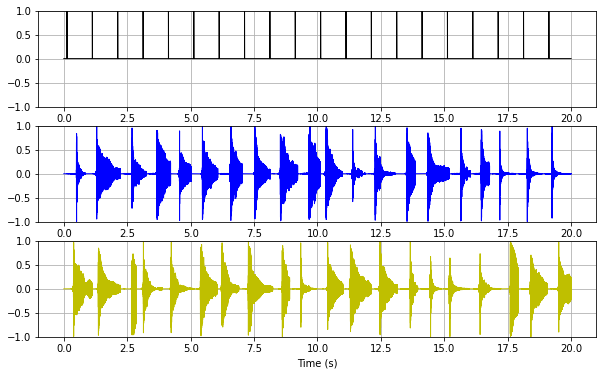

In [ ]:
input_file = file_list[4]
target_file = input_file.replace('input','target')
print(input_file)
print(target_file)
input, sr = load_as_mc(input_file, file_list)
show_audio(input, sr)

Shape: (3, 320000), Dtype: torch.float32, Duration: 20.0 s
Max:  1.000,  Min: -1.000, Mean:  0.000, Std Dev:  0.096


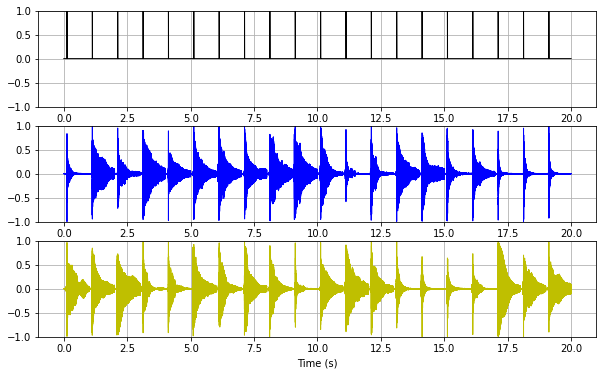

In [ ]:
target, sr = load_as_mc(target_file, file_list)
show_audio(target, sr)